In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from scikeras.wrappers import KerasRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
def naive_roc_auc_score(y_true, y_pred):
  
  y_true = y_true.to_numpy()
  
  num_same_sign = 0
  num_pairs = 0
  
  for a in range(len(y_true)):
    for b in range(len(y_true)):
      if y_true[a] > y_true[b]:
        num_pairs += 1
        if y_pred[a] > y_pred[b]:
          num_same_sign += 1
        elif y_pred[a] == y_pred[b]:
          num_same_sign += .5
        
  return num_same_sign / num_pairs

# score = make_scorer(naive_roc_auc_score, greater_is_better=True)

In [37]:
def create_model():
 # create model
 model = Sequential()
 model.add(Dense(29, input_shape=(29,), activation='elu'))
 model.add(BatchNormalization())
 model.add(Dense(30, activation='elu'))
 model.add(BatchNormalization())
 model.add(Dropout(rate=0.3))
#  model.add(Dense(30, activation='elu'))
#  model.add(BatchNormalization())
#  model.add(Dropout(rate=0.3))
 model.add(Dense(20, activation='elu'))
 model.add(BatchNormalization())
 model.add(Dense(10, activation='elu'))
 model.add(BatchNormalization())
 model.add(Dense(1))
 model.add(BatchNormalization())
 # Compile model
 opt = optimizers.Adam(learning_rate=0.02)
 model.compile(loss='MeanSquaredError', optimizer=opt, metrics=['accuracy'])
 return model

In [38]:
data = pd.read_csv('CP_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
scaler = StandardScaler().fit(X_train[list_numerical])
X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])

In [39]:
seed = 7
tf.random.set_seed(seed)
# load dataset
# create model
model = KerasRegressor(model=create_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv)
grid_cv = grid.fit(X_train, y_train)
# summarize results
print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print('Train Mean Absolute Error:', abs(grid_cv.predict(X_train) - y_train), 'degrees.')
print('Test Mean Absolute Error:', abs(grid_cv.predict(X_test) - y_test), 'degrees.')

# prediction = model.predict(X_test)
# mse = mean_squared_error(y_test, prediction)
# #calculate R-squared of regression model
# r_squared = model.score(X_test, y_test)

#view R-squared value
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'batch_size': 10, 'epochs': 10}
CV score for GS 0.11364228594093892
Train AUC ROC Score for GS:  0.6613329648411876
Test AUC ROC Score for GS:  0.6603144354454502
Train Mean Absolute Error: 842    0.007615
783    0.082706
809    0.598145
613    0.183949
602    0.205499
         ...   
382    0.000969
327    0.128483
551    0.224268
127    0.143541
272    0.027441
Name: -LUMO(eV), Length: 780, dtype: float64 degrees.
Test Mean Absolute Error: 424    0.198929
176    0.062910
807    0.118139
371    0.068886
615    0.154406
         ...   
218    0.278255
563    0.016867
452    0.024366
810    0.522821
705    0.163349
Name: -LUMO(eV), Length: 196, dtype: float64 degrees.
Train R2:  0.20704608306302186
Test R2:  0.17393097132689017
Train MSE:  0.06954365172192799
Test MSE:  0.0799522142701472


In [6]:
def create_new_model():
 # create model
 model = Sequential()
 model.add(Dense(29, input_shape=(29,), activation='elu'))
#  model.add(BatchNormalization())
 model.add(Dense(30, activation='elu'))
#  model.add(BatchNormalization())
#  model.add(Dense(30, activation='elu'))
#  model.add(BatchNormalization())
#  model.add(Dropout(rate=0.3))
 model.add(Dense(20, activation='elu'))
#  model.add(BatchNormalization())
 model.add(Dense(10, activation='elu'))
#  model.add(BatchNormalization())
 model.add(Dense(1))
#  model.add(BatchNormalization())
 # Compile model
 opt = optimizers.Adam(learning_rate=0.02)
 model.compile(loss='MeanSquaredError', optimizer=opt, metrics=['accuracy'])
 return model

In [7]:
seed = 7
tf.random.set_seed(seed)
# load dataset
# create model
model = KerasRegressor(model=create_new_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv)
grid_cv = grid.fit(X_train, y_train)
# summarize results
print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print('Train Mean Absolute Error:', abs(grid_cv.predict(X_train) - y_train), 'degrees.')
print('Test Mean Absolute Error:', abs(grid_cv.predict(X_test) - y_test), 'degrees/.')

# prediction = model.predict(X_test)
# mse = mean_squared_error(y_test, prediction)
# #calculate R-squared of regression model
# r_squared = model.score(X_test, y_test)

#view R-squared value
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'batch_size': 80, 'epochs': 10}
CV score for GS 0.05239203246256765
Train AUC ROC Score for GS:  0.6653269979322263
Test AUC ROC Score for GS:  0.6750304377746017
Train Mean Absolute Error: 842    0.132711
783    0.045280
809    0.525841
613    0.249167
602    0.412969
         ...   
382    0.085562
327    0.374408
551    0.382254
127    0.333204
272    0.158255
Name: -LUMO(eV), Length: 780, dtype: float64 degrees.
Test Mean Absolute Error: 424    0.180857
176    0.000761
807    0.195519
371    0.127776
615    0.124260
         ...   
218    0.405266
563    0.109945
452    0.124529
810    0.441609
705    0.123179
Name: -LUMO(eV), Length: 196, dtype: float64 degrees/.
Train R2:  0.15205964811485095
Test R2:  0.12370997284624674
Train MSE:  0.0743660725458735
Test MSE:  0.08481292190112419


In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_val, y_val))

KerasRegressor(
	model=<function create_new_model at 0x290cf0790>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
)

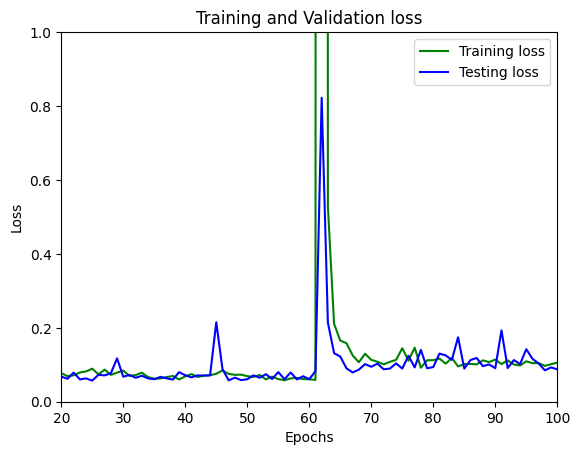

In [12]:
loss_train = model.history_['loss']
loss_val = model.history_['val_loss']
epochs = range(1,101)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Testing loss')
plt.xlim(20, 100)
plt.ylim(0, 1)
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
loss_train

[1.2689028978347778,
 0.21816539764404297,
 0.19056686758995056,
 0.19472765922546387,
 0.20406031608581543,
 0.09234460443258286,
 0.08720669895410538,
 0.08277112245559692,
 0.07970259338617325,
 0.09121406078338623,
 0.08053544163703918,
 0.08483073860406876,
 0.07346469908952713,
 0.07974220812320709,
 0.07594682276248932,
 0.07686507701873779,
 0.08091208338737488,
 0.07032172381877899,
 0.07141000777482986,
 0.07716938108205795,
 0.06930588185787201,
 0.0714806541800499,
 0.07904785126447678,
 0.08200202137231827,
 0.08935804665088654,
 0.0739692896604538,
 0.08687882870435715,
 0.0726674422621727,
 0.0786823257803917,
 0.08429215848445892,
 0.06978794932365417,
 0.07213446497917175,
 0.07857870310544968,
 0.06665175408124924,
 0.06236974522471428,
 0.06293284147977829,
 0.06673378497362137,
 0.06955445557832718,
 0.060277946293354034,
 0.06863660365343094,
 0.07470670342445374,
 0.06704916805028915,
 0.07017888128757477,
 0.07177691906690598,
 0.07562433928251266,
 0.08458670228